In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from model import Model
from dataloader import databunch_from_csv
from utils import threshold_predictions, check_acc
from fastai.vision import models
import constants

In [3]:
label_file = 'train_tags_combined.csv'

In [4]:
data = databunch_from_csv(csv_name=label_file, path=constants.dataset_folder,
                          img_size=constants.initial_dimension, vertical_flip=False,
                          batch_size=constants.batch_size, frac_validation=0.25)

## Building Model

The model built has `245` output nodes and the activation function before last layer is `sigmoid` as opposed to `softmax` layer which is generally used in classification task. The main reason behind this decision is allowing the model to make multiple predictions simultaneously and thresholding afterwards to get final prediction outputs. When it come to recognizing cars, allowing the model to make multiple predictions is beneficial. For example, there are quite a few cars manufacturers which does brand engineering for certain models and thus the resulting vehicles look pretty much the same except few differences (e.g. [Toyota GT86 and Subaru BRZ](https://images.pistonheads.com/nimg/26168/BRZvsGT86_22-L.jpg)). Allowing the model to make multiple predictions can allow the model to produce independent probability outputs. In the case with [Toyota GT86 and Subaru BRZ](https://images.pistonheads.com/nimg/26168/BRZvsGT86_22-L.jpg), it is reasonable for a model to produce high probability for output nodes corresponding to Toyota and Subaru as well as high probability for output nodes corresponding to GT86 and BRZ.

ResNet50 is used as the architecture. Pretrained weights on Imagenet are used as initial weights for convolutional layers.

In [5]:
class_names = data.classes
learn = Model(threshold=0.5, databunch=data, arch=models.resnet50)

## Training Model

Finding a good initial learning rate for freezed model (only the newly added layers are trained).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


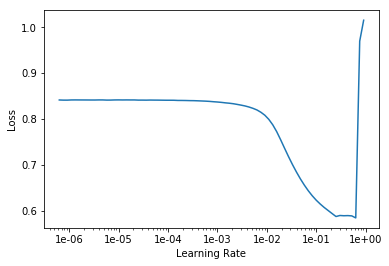

In [6]:
learn.learn.lr_find()
learn.learn.recorder.plot()

Model is trained with cyclical learning rate with early stopping.

In [7]:
learn.train_model(lr=5E-02, high_lr=None, epochs=15, freeze=True)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.035532,0.025856,0.993178,0.201037,02:36
1,0.021507,0.016712,0.995071,0.451288,02:36
2,0.019814,0.016364,0.995297,0.492854,02:36
3,0.020834,0.017899,0.995052,0.457169,02:31
4,0.019592,0.020710,0.995221,0.495724,02:28


Epoch 5: early stopping


In [8]:
learn.learn.save('cars_model_stage1')

Unfreeze the model, find a new learning rate, 

## Fine Tuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


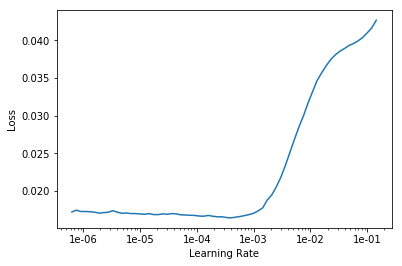

In [10]:
learn.learn.unfreeze()
learn.learn.lr_find()
learn.learn.recorder.plot()

## Aggressive Fine Tuning

In [13]:
learn.train_model(lr=4e-06, high_lr=5E-03, epochs=15, freeze=False)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.004317,0.003719,0.998748,0.867731,02:39
1,0.003877,0.003561,0.998796,0.871584,02:39
2,0.003976,0.004100,0.998781,0.874384,02:39
3,0.003846,0.003429,0.998851,0.881620,02:39
4,0.003397,0.003173,0.998945,0.893970,02:38


Epoch 5: early stopping


In [19]:
learn.train_model(lr=4e-06, high_lr=5E-03, epochs=15, freeze=False)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.001100,0.001702,0.999476,0.947848,02:38
1,0.001022,0.006211,0.999395,0.948874,02:41
2,0.001080,0.001799,0.999446,0.946799,02:41
3,0.001215,0.002067,0.999381,0.937471,02:41
4,0.001251,0.001940,0.999441,0.947720,02:39


Epoch 5: early stopping


In [20]:
learn.learn.save('cars_model_stage2')